### (c) Models and metrics

The following models are estimated:
- linear regression without any of the constructed variables (baseline)
- linear regressions with the constructed variables in addition to the baseline model
- Huber regressions with the constructed variables in addition to the basineline model
- Ridge and Lasso regressions with the constructed variables in addition to the basineline model
- Random Forest with the constructed variables in addition to the basineline model
- AdaBoost and XGBoost with the constructed variables in addition to the basineline model

A validation set is used to fine-tune the hyper-parameters.

We also experiment with a slightly larger set of variables (with the drawback of having less observations), cross-validation instead of a validation set, airbnb prices instead of log, and PCA (principal component analysis) as a preprocessing step.

Huber, Ridge and Lasso contain a regularization term. Regularization is helpful to deal with overfitting. Random Forest is a bagging method where the results of many weak learners are aggregated to reduced variance. An advantage of Random Forest is that the algorithm is parallelizable. AdaBoost and XGBoosts are boosting methods where weak learners are trained sequentially with the aim to improve predictions (https://medium.com/greyatom/a-quick-guide-to-boosting-in-ml-acf7c1585cb5). Due to the sequential architecture boosting algorithms are usually slower than bagging approaches.

Linear, Huber, Lasso and Ridge regression are computationally fast to learn because no or not a lot of hyper-parameters have to be fine-tuned and because only one instance of the model is estimated. The latter has also the effect that these models are easier to interpret and coefficient and errors of the coefficient estimations can be computed. In contrast to these algorithms, bagging and boosting algorithmns consists of learning many weak learners and usually a lot of hyper-parameters. It is clear that these algorithmns need much more computing power and time. We see it also in this project.

Three different metrics are considered to evaluate the performance of the different approaches:
- $R^2$ score, which defines the fraction of variability that can be explained by the model (https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score)
- RMSE (root mean squared error): $ \sqrt{\frac{1}{n} \sum_{i=1}^n (\hat{Y}_i - Y_i )^2}$, where $\hat{Y}_i$ is the predicted and $Y_i$ the true value.
- MAE (mean absolute error): $ \frac{1}{n} \sum_{i=1}^n |\hat{Y}_i - Y_i |$, where $\hat{Y}_i$ is the predicted and $Y_i$ the true value.

<!---
EXPLAIN APPROACH 
- baseline model why to use these variables
- grid search / randomized search
- improvements (estimation of prices instead of log prices, more variables, pca of some or all variables

Links <br>
https://scikit-learn.org/stable/modules/cross_validation.html#predefined-fold-splits-validation-sets <br>
https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn <br>
https://pypi.org/project/hypopt/ <br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html <br>
https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net <br>

Scaling <br>
https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm

XGBoost <br>
https://www.datacamp.com/community/tutorials/xgboost-in-python <br>
https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7 <br>
*Parameters* <br>
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ <br>
https://xgboost.readthedocs.io/en/latest/python/python_api.html -> go to Scikit-Learn API for the parameters
https://xgboost.readthedocs.io/en/latest/parameter.html

Accuracy: https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/
--->

In the following, the different models are estimated and the results are presented. The larger the $R^2$-score and the lower the RMSE and MAE the better is a model. If possible we compare the results obtained with `sklearn` to the ones estimated with `statsmodel`.

In [271]:
def prepare_datasets(X, y):
    
    """
    Parameters
    ----------
        X: ``numpy.array``
            The explanatory values of the training/test set
        y: ``numpy.array``
            The target values of the training/test set
    
    Returns
    -------
        X and y without nan and inf values.
    """
    
    X = np.c_[X, y]
    X = X[~np.isnan(X).any(axis=1)]
    X = X[~np.isinf(X).any(axis=1)]
    y = X[:, X.shape[1]-1]
    X = X[:, range(X.shape[1]-1)]
    
    return (X, y)

In [272]:
def model_estimation(train, 
                     model,
                     param_grid=None, 
                     grid_search_type=None,
                     n_iter = None,
                     validation = None,
                     cv = None,
                     back_transform = False,
                     file_path=None):
    """
    
    This is a wrapper for doing the grid search inclusively to
    compute the r2 score, mse, mae for the untransformed and 
    transformed model and to save the model.
    
    Parameters
    -----------
        train: a tuple of DataFrames
            The regressors and the target variable of the training 
            set as a tuple. The dataset can contain 
            missing values.
        model: sklearn model instance or pipeline instance
            The model or pipeline to be fitted.
        param_grid: Dict, default None
            A dictionary with the parameters for the grid search.
        grid_search_type: string, default None
            Either 'GridSearchCV, 'RandomizedSearchCV' or None
        n_iter: int, default None
            The number of draws for 'RandomizedSearchCV'
        validation: a tuple of DataFrames, default None
            The regressors and the target variable of the validation 
            set as a tuple. The dataset can contain 
            missing values.
        cv: int
            The number of cross-validation folds. 
        back_transform: boolean, default False
            If True, the values are back transformed.
        file_path: string, default None
            The file name. If None, the model is not saved
            to disk.
    
    Returns
    -------
    A dictionary with the fitted model ('model') and the r2 score of the 
    in-sample fit ('score') and the number of the observations in the 
    training set.
        
        
    Rk.: The function uses the function `prepare_datasets`.
    """
    
    model = copy.deepcopy(model)
    
    # clean datasets
    X_train, y_train = prepare_datasets(train[0], train[1])
    nobs = X_train.shape[0]
    
    X_for_score = X_train.copy()
    y_for_score = y_train.copy()
    
    # validation set (optional)
    if validation is not None:
        X_valid, y_valid = prepare_datasets(validation[0], validation[1])
        
        valid_fold = [-1]*X_train.shape[0] + [0]*X_valid.shape[0]
        valid_fold = np.array(valid_fold)
        
        ps = PredefinedSplit(test_fold=valid_fold)
        
        X_train = np.concatenate((X_train, X_valid))
        y_train = np.concatenate((y_train, y_valid))
    else:
        ps = None
        
    # grid search preparation (optional)
    if validation is not None:
        if grid_search_type == 'GridSearchCV':
            model = GridSearchCV(model, param_grid=param_grid, cv=ps)
        elif grid_search_type == 'RandomizedSearchCV':
            model = RandomizedSearchCV(model, param_distributions=param_grid, 
                                       cv=ps, n_iter=n_iter, random_state=1)
    if cv is not None:
        if grid_search_type == 'GridSearchCV':
            model = GridSearchCV(model, param_grid=param_grid, cv=cv)
        elif grid_search_type == 'RandomizedSearchCV':
            model = RandomizedSearchCV(model, param_distributions=param_grid, 
                                       cv=cv, n_iter=n_iter, random_state=1)
     
    # Model estimation
    fitted_model = model.fit(X_train, y_train)
    
    # In-sample fit
    # -------------
    # Untransformed
    predicted = fitted_model.predict(X_train)
    train_r2 = r2_score(y_train, predicted)
    train_mse = mean_squared_error(y_train, predicted)
    train_mae = mean_absolute_error(y_train, predicted)
    
    # Transformed
    if back_transform:
        predicted_trans = 10**(predicted)
        y_train_trans = 10**(y_train)
        train_r2_trans = r2_score(y_train_trans, predicted_trans)
        train_mse_trans = mean_squared_error(y_train_trans, predicted_trans)
        train_mae_trans = mean_absolute_error(y_train_trans, predicted_trans)
    else:
        predicted_trans = None
        y_train_trans = None
        train_r2_trans = None
        train_mse_trans = None
        train_mae_trans = None
    
    # Validation fold
    if validation is not None:
        used_for_valid = valid_fold.copy() 
        used_for_valid[used_for_valid == -1] = False
        used_for_valid[used_for_valid == 0] = True
    else:
        used_for_valid = [False]*X_train.shape[0]
    used_for_valid = np.array(used_for_valid)
    
    res = {'model': copy.deepcopy(fitted_model), 
           'train_r2': train_r2,
           'train_mse': train_mse,
           'train_mae': train_mae,
           'train_r2_transformed': train_r2_trans,
           'train_mse_transformed': train_mse_trans,
           'train_mae_transformed': train_mae_trans,
           'used_for_validation': used_for_valid,
           'nobs': nobs}
    
    # Save to disk
    if file_path is not None:
        pickle.dump(res, open(file_path, 'wb'))
        
    return res

In [273]:
def plot(predicted, true, t, transformation=None, add_density_plots=False):
    
    """
    Helper function for plotting the results.
    
    Parameters
    ----------
        predicted: array-like.
            The predicted values.
        true: array-like
            The true values.
        t: string
            The type. Either 'train' or 'test'.
        transformation: string, default None
            How to back transform the values. Either None, 'Power of 10'
            or 'both'.
        add_density_plots: boolean, default False
            If True seaborn kdeplots and rugplots are added to the output.
            See https://seaborn.pydata.org/tutorial/distributions.html for
            more informations.
    
    """
    if t == 'train':
        col_dots = 'royalblue'
    elif t == 'test':
        col_dots = 'crimson'
    
    col_line = 'black'

    if transformation == 'Power of 10' or transformation == 'both':
        predicted_back_trans = 10**(predicted)
        true_back_trans = 10**(true)
        min_val_back_trans = min(min(predicted_back_trans), min(true_back_trans))
        max_val_back_trans = max(max(predicted_back_trans), max(true_back_trans))
        min_val = min(min(predicted), min(true))
        max_val = max(max(predicted), max(true))
    else:
        min_val = min(min(predicted), min(true))
        max_val = max(max(predicted), max(true))
    
    # Plots
    if transformation == 'both':
        
        if add_density_plots:
            fig, ax = plt.subplots(1, 4, figsize=(20,5))
        else:
            fig, ax = plt.subplots(1, 2, figsize=(10,5))
            
        if t == 'train':
            fig.suptitle('In-sample predictions')
        elif t == 'test':
            fig.suptitle('Out-of-sample predictions')
        
        #plt.gca().set_aspect('equal', adjustable='box')
        
        # Scatter plots
        ax[0].scatter(predicted, true, color=col_dots, s=2)
        #ax[0].set_title("Predicted vs true log prices")
        ax[0].set_title("Predicted vs true")
        ax[0].set_xlabel('Predicted')
        ax[0].set_ylabel('True')
        ax[0].set_xlim([min_val, max_val])
        ax[0].set_ylim([min_val, max_val])
        ax[0].plot([min_val, max_val], [min_val, max_val], color=col_line)
        ax[0].set_aspect('equal', 'box')
        
        ax[1].scatter(predicted_back_trans, true_back_trans, color=col_dots, s=2)
        #ax[1].set_title("Transformed: Predicted vs true prices")
        ax[1].set_title("Transformed: Predicted vs true")
        ax[1].set_xlabel('Predicted')
        ax[1].set_ylabel('True')
        ax[1].set_xlim([min_val_back_trans, max_val_back_trans])
        ax[1].set_ylim([min_val_back_trans, max_val_back_trans])
        ax[1].plot([min_val_back_trans, max_val_back_trans], [min_val_back_trans, max_val_back_trans], color=col_line)
        ax[1].set_aspect('equal', 'box')
        
        # Add density plots
        if add_density_plots:
            sns.kdeplot(predicted, true, ax=ax[2], shade=False, color=col_dots)
            sns.rugplot(predicted, ax=ax[2], color=col_dots)
            sns.rugplot(true, vertical=True, ax=ax[2], color=col_dots)
            #ax[2].set_title("Predicted vs true log prices")
            ax[2].set_title("Predicted vs true")
            ax[2].set_xlabel('Predicted')
            ax[2].set_ylabel('True')
            ax[2].set_xlim([min_val, max_val])
            ax[2].set_ylim([min_val, max_val])
            ax[2].plot([min_val, max_val], [min_val, max_val], color=col_line)
            ax[2].set_aspect('equal', 'box')
        
            sns.kdeplot(predicted_back_trans, true_back_trans, ax=ax[3], shade=False, color=col_dots)
            sns.rugplot(predicted_back_trans, ax=ax[3], color=col_dots)
            sns.rugplot(true_back_trans, vertical=True, ax=ax[3], color=col_dots)
            #ax[3].set_title("Transformed: Predicted vs true prices")
            ax[3].set_title("Transformed: Predicted vs true")
            ax[3].set_xlabel('Predicted')
            ax[3].set_ylabel('True')
            ax[3].set_xlim([min_val_back_trans, max_val_back_trans])
            ax[3].set_ylim([min_val_back_trans, max_val_back_trans])
            ax[3].plot([min_val_back_trans, max_val_back_trans], [min_val_back_trans, max_val_back_trans], color=col_line)
            ax[3].set_aspect('equal', 'box')
        
    elif transformation == 'Power of 10':
        
        if add_density_plots:
            fig, ax = plt.subplots(1, 2, figsize=(10,5))
        else:
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
        
        #fig, ax = plt.subplots(1, 1, figsize=(5,5))
        if t == 'train':
            fig.suptitle('In-sample predictions')
        elif t == 'test':
            fig.suptitle('Out-of-sample predictions')
        
        if add_density_plots == False:
            ax.scatter(predicted_back_trans, true_back_trans, color=col_dots, s=2)
            #ax.set_title("Transformed: Predicted vs true prices")
            ax.set_title("Transformed: Predicted vs true")
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xlim([min_val_back_trans, max_val_back_trans])
            ax.set_ylim([min_val_back_trans, max_val_back_trans])
            ax.plot([min_val_back_trans, max_val_back_trans], [min_val_back_trans, max_val_back_trans], color=col_line)
            ax.set_aspect('equal', 'box')
        elif add_density_plots:
            ax[0].scatter(predicted_back_trans, true_back_trans, color=col_dots, s=2)
            #ax[0].set_title("Transformed: Predicted vs true prices")
            ax[0].set_title("Transformed: Predicted vs true")
            ax[0].set_xlabel('Predicted')
            ax[0].set_ylabel('True')
            ax[0].set_xlim([min_val_back_trans, max_val_back_trans])
            ax[0].set_ylim([min_val_back_trans, max_val_back_trans])
            ax[0].plot([min_val_back_trans, max_val_back_trans], [min_val_back_trans, max_val_back_trans], color=col_line)
            ax[0].set_aspect('equal', 'box')
        
        # Add density plots
        if add_density_plots:
            sns.kdeplot(predicted_back_trans, true_back_trans, ax=ax[1], shade=False, color=col_dots)
            sns.rugplot(predicted_back_trans, ax=ax[1], color=col_dots)
            sns.rugplot(true_back_trans, vertical=True, ax=ax[1], color=col_dots)
            #ax[1].set_title("Transformed: Predicted vs true prices")
            ax[1].set_title("Transformed: Predicted vs true")
            ax[1].set_xlabel('Predicted')
            ax[1].set_ylabel('True')
            ax[1].set_xlim([min_val_back_trans, max_val_back_trans])
            ax[1].set_ylim([min_val_back_trans, max_val_back_trans])
            ax[1].plot([min_val_back_trans, max_val_back_trans], [min_val_back_trans, max_val_back_trans], color=col_line)
            ax[1].set_aspect('equal', 'box')
    else: 
        
        if add_density_plots:
            fig, ax = plt.subplots(1, 2, figsize=(10,5))
        else:
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
        
        if t == 'train':
            fig.suptitle('In-sample predictions')
        elif t == 'test':
            fig.suptitle('Out-of-sample predictions')
        
        if add_density_plots == False:
            ax.scatter(predicted, true, color=col_dots, s=2)
            #ax.set_title("Predicted vs true log prices")
            ax.set_title("Predicted vs true")
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xlim([min_val, max_val])
            ax.set_ylim([min_val, max_val])
            ax.plot([min_val, max_val], [min_val, max_val], color=col_line)
            ax.set_aspect('equal', 'box')
        elif add_density_plots:
            ax[0].scatter(predicted, true, color=col_dots, s=2)
            #ax[0].set_title("Predicted vs true log prices")
            ax[0].set_title("Predicted vs true")
            ax[0].set_xlabel('Predicted')
            ax[0].set_ylabel('True')
            ax[0].set_xlim([min_val, max_val])
            ax[0].set_ylim([min_val, max_val])
            ax[0].plot([min_val, max_val], [min_val, max_val], color=col_line)
            ax[0].set_aspect('equal', 'box')
        
        # Add density plots
        if add_density_plots:
            sns.kdeplot(predicted, true, ax=ax[1], shade=False, color=col_dots)
            sns.rugplot(predicted, ax=ax[1], color=col_dots)
            sns.rugplot(true, vertical=True, ax=ax[1], color=col_dots)
            #ax[1].set_title("Predicted vs true log prices")
            ax[1].set_title("Predicted vs true")
            ax[1].set_xlabel('Predicted')
            ax[1].set_ylabel('True')
            ax[1].set_xlim([min_val, max_val])
            ax[1].set_ylim([min_val, max_val])
            ax[1].plot([min_val, max_val], [min_val, max_val], color=col_line)
            ax[1].set_aspect('equal', 'box')

In [274]:
def print_results(file_path, test, train, transformation=None, add_density_plots=False):
    
    """
    Parameters
    ----------
        file_path: string, default None
            The file path to the dictionary of the fitted model or 
            pipeline
        test: a tuple of DataFrames
            The regressors and the target variable of the test 
            set as a tuple. The dataset can contain 
            missing values.
        train: a tuple of DataFrames
            The regressors and the target variable of the train 
            set as a tuple. The dataset can contain 
            missing values.
        transformation: string, default None
            How to transform the values. Either None, 'Power of 10'
            or 'both'.
        add_density_plots: boolean, default False
            If True seaborn kdeplots and rugplots are added to the output.
            See https://seaborn.pydata.org/tutorial/distributions.html for
            more informations.
    
    This function uses `prepare_datasets()` and `plot()`. 
    """
    
    # load the estimated model
    res = pickle.load(open(file_path, 'rb'))
    fitted_model = res['model']
    
    # Number of observations
    nobs = res['nobs']
    
    # clean the test set
    # ------------------
    X_train, y_train = prepare_datasets(train[0], train[1])
    X_test, y_test = prepare_datasets(test[0], test[1])
    
    # predict
    in_sample_pred = fitted_model.predict(X_train)
    predicted = fitted_model.predict(X_test)
    
    # Scores and errors train set
    # ---------------------------
    # Untransformed
    train_r2 = r2_score(y_train, in_sample_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, in_sample_pred))
    train_mae = mean_absolute_error(y_train, in_sample_pred)
    
    # Transformed
    if transformation is not None:
        in_sample_pred_trans = 10**(in_sample_pred)
        y_train_trans = 10**(y_train)
        train_r2_trans = r2_score(y_train_trans, in_sample_pred_trans)
        train_rmse_trans = np.sqrt(mean_squared_error(y_train_trans, in_sample_pred_trans))
        train_mae_trans = mean_absolute_error(y_train_trans, in_sample_pred_trans)
    else:
        in_sample_pred_trans = None
        y_train_trans = None
        train_r2_trans = None
        train_rmse_trans = None
        train_mae_trans = None
    
    # Scores test set
    # ---------------
    # Untransformed
    test_r2 = r2_score(y_test, predicted)
    test_rmse = np.sqrt(mean_squared_error(y_test, predicted))
    test_mae = mean_absolute_error(y_test, predicted)
    
    # Transformed
    if transformation is not None:
        predicted_trans = 10**(predicted)
        y_test_trans = 10**(y_test)
        test_r2_trans = r2_score(y_test_trans, predicted_trans)
        test_rmse_trans = np.sqrt(mean_squared_error(y_test_trans, predicted_trans))
        test_mae_trans = mean_absolute_error(y_test_trans, predicted_trans)
    else:
        predicted_trans = None
        y_test_trans = None
        test_r2_trans = None
        test_rmse_trans = None
        test_mae_trans = None
    
    # print
    if transformation in ['both', None]:
        print('Untransformed')
        print('-------------')
        print('{} {:04.2f} {} {:04.2f} {} {:04.2f} {} {}'.format('R2 train:', train_r2, '/ RMSE train', train_rmse, '/ MAE train', train_mae, '/ Nobs:', X_train.shape[0]))
        print('{} {:04.2f} {} {:04.2f} {} {:04.2f} {} {}'.format('R2 test:', test_r2, '/ RMSE test', test_rmse, '/ MAE test', test_mae, '/ Nobs:', X_test.shape[0]))
    if transformation in ['both', 'Power of 10']:
        print('')
        print('Transformed')
        print('-----------')
        print('{} {:04.2f} {} {:04.2f} {} {:04.2f} {} {}'.format('R2 train:', train_r2_trans, '/ RMSE train', train_rmse_trans, '/ MAE train', train_mae_trans, '/ Nobs:', X_train.shape[0]))
        print('{} {:04.2f} {} {:04.2f} {} {:04.2f} {} {}'.format('R2 test:', test_r2_trans, '/ RMSE test', test_rmse_trans, '/ MAE test', test_mae_trans, '/ Nobs:', X_test.shape[0]))
        print('')
    
    # plot
    plot(in_sample_pred, y_train, 'train', transformation, add_density_plots)
    plot(predicted, y_test, 'test', transformation, add_density_plots)
    
    
    return {'predicted': predicted,
            'y_test': y_test,
            'train_r2': train_r2,
            'train_rmse': train_rmse,
            'train_mae': train_mae,
            'train_r2_transformed': train_r2_trans,
            'train_rmse_transformed': train_rmse_trans,
            'train_mae_transformed': train_mae_trans,
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_r2_transformed': test_r2_trans,
            'test_rmse_transformed': test_rmse_trans,
            'test_mae_transformed': test_mae_trans,
            'fitted_model': copy.deepcopy(fitted_model)}

**0. Baseline model**

The baseline model is a linear regression on the features `Air_calculated_host_listings_count`, `Air_bathrooms`, `Air_beds`, `Air_bedrooms`, `Air_accommodates`, `Air_extra_people`, `Air_guests_included`, `Air_distance_to_CBD`, `Air_property_type_2`, `Air_room_type`, `Air_cancellation_policy_2`, `Air_neighbourhood_cleansed`. All other models contain one or three more variables.

Untransformed
-------------
R2 train: 0.61 / RMSE train 0.17 / MAE train 0.13 / Nobs: 14266
R2 test: 0.63 / RMSE test 0.16 / MAE test 0.12 / Nobs: 4456

Transformed
-----------
R2 train: 0.48 / RMSE train 62.04 / MAE train 37.72 / Nobs: 14266
R2 test: 0.49 / RMSE test 61.08 / MAE test 36.74 / Nobs: 4456



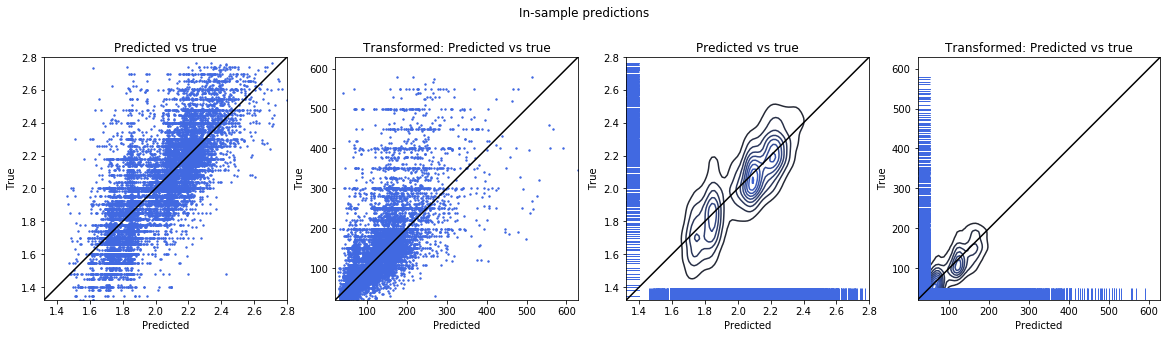

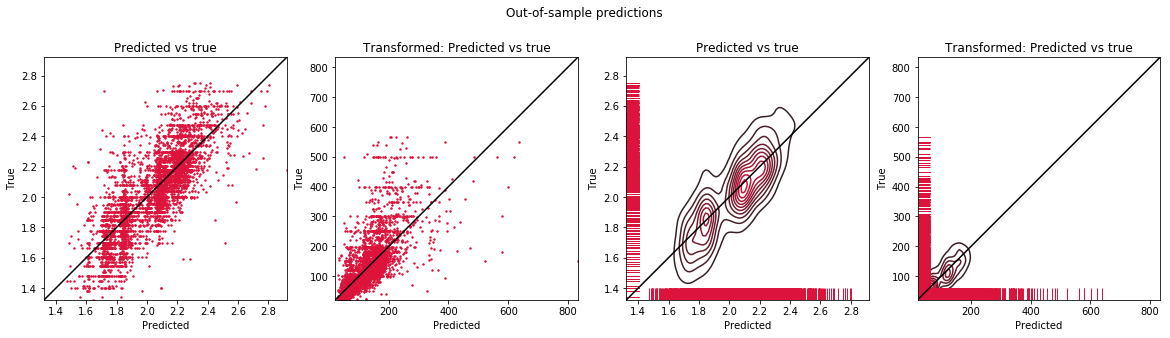

In [275]:
train_tpl = (X_train_base, y_train_base)
test_tpl = (X_test_base, y_test_base)
base = print_results('linear_regression_base.p', test_tpl, train_tpl, 'both', True)

In [276]:
df = pd.DataFrame(data={'Coefficient': list(base['fitted_model'].coef_)})
df.index = [c for c in list(train_base.columns) if c != 'Air_log_price']
df

,Coefficient
Air_calculated_host_listings_count,-0.000134
Air_bathrooms,0.041846
Air_beds,-0.003577
Air_bedrooms,0.071544
Air_accommodates,0.017561
Air_extra_people,0.000388
Air_guests_included,0.005790
Air_distance_to_CBD,-0.003803
Air_property_type_2_House_Cottage_Villa,0.009814
Air_property_type_2_Other,0.056793


To get a better overview over the relevance of the variables the model is also estimated with `statsmodels`. We see from the output that there might be an issue with muliticollinearity which can results in biased coefficients and uncorrect error estimations but this is not a huge problem in our case since we are mainly interested in predictions.

In [277]:
X, y = prepare_datasets(X_train_base, y_train_base)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = [c for c in train_base.columns if c != 'Air_log_price']
y.columns = ['Air_log_price']
X = sm.add_constant(X)
base_sm = sm.OLS(y, X).fit()
print(base_sm.summary())

                            OLS Regression Results                            
Dep. Variable:          Air_log_price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     499.3
Date:                Wed, 08 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:09:56   Log-Likelihood:                 5137.2
No. Observations:               14266   AIC:                        -1.018e+04
Df Residuals:                   14221   BIC:                            -9844.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

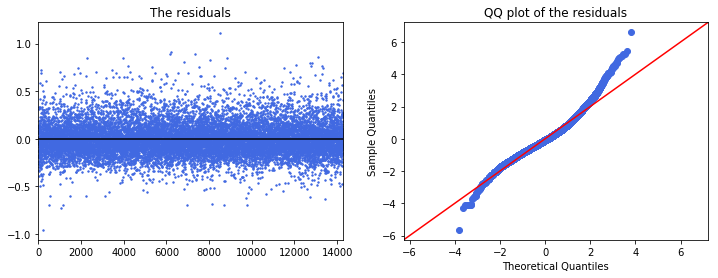

In [278]:
mean = np.mean(base_sm.resid)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(x=range(base_sm.resid.shape[0]), y=base_sm.resid, alpha=1, s=2, color=col1)
ax[0].set_title("The residuals")
ax[0].axhline(mean, color='black')
ax[0].set_xlim(0, base_sm.resid.shape[0])
stdized = (base_sm.resid - np.mean(base_sm.resid)) / np.std(base_sm.resid)
sm.qqplot(stdized, line='45', color=col1, ax=ax[1])
ax[1].set_title("QQ plot of the residuals");